In [16]:
# Imports
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mtplt
import numpy as np
import cv2
import math
import os

## Why use SIFT over ORB?
SIFT is better than ORB for stitching the Skerki dataset because it is more robust to scale, rotation, and illumination changes, which are common challenges in underwater imagery. The low contrast and variable lighting in the Skerki dataset make SIFT's gradient-based feature descriptors particularly useful for detecting and matching keypoints reliably, even in textureless or poorly lit regions. While ORB is faster, it is less effective in handling significant lighting variations and scale differences, which are critical in this challenging dataset.

In [17]:
class ImageMosiacking:
    """
    A class to perform perform image mosiacking operations on the Skerski dataset using GTSAM.
    """

    def __init__(self, image_directory):
        """
        Initializes the ImageMosiacking class with placeholder values.
        """
        self.images = []

        # Image directory
        self.image_directory = image_directory

        # initialize SIFT feature detector.
        self.sift = cv2.SIFT.create()

    def get_images_for_mosaicking(self):
        """
        Loads all images from the specified subdirectory for mosaicking.
        """
        # Get the current working directory
        current_dir = os.getcwd()

        # Create the full path to the subdirectory
        full_path = os.path.join(current_dir, self.image_directory)

        # Loop through all files in the subdirectory
        for filename in os.listdir(full_path):
            # Create the full path to the image file
            file_path = os.path.join(full_path, filename)

            # Check if the file is an image based on file extension
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                # Load the image using OpenCV
                image = cv2.imread(file_path)

                # If the image is loaded correctly, append it to the list
                if image is not None:
                    self.images.append(image)
                else:
                    print(f"Warning: Failed to load {filename}")

        for image in self.images:
            plt.imshow(image)
            plt.show()

    def get_features(self):
        """
        Detects SIFT keypoints and descriptors for each image in `self.images`, stores them in
        `self.keypoints` and `self.descriptors`, and visualizes the keypoints on the grayscale images.

        Keypoints and descriptors are extracted from each image after conversion to grayscale for
        efficiency. The detected keypoints are drawn on the images and displayed using Matplotlib.

        Attributes:
            self.keypoints (list): Keypoints detected in each image.
            self.descriptors (list): Corresponding descriptors for the keypoints.

        """
        self.keypoints = []
        self.descriptors = []
        i = 0
        for image in self.images:

            # Convert image to grayscale to reduce the computational load on SIFT by reducing
            # intensity to a single channel.
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Get keypoints and descriptors.
            keypoints, descriptors = self.sift.detectAndCompute(gray_image, None)

            self.keypoints.append(keypoints)
            self.descriptors.append(descriptors)

            # Draw and plot the keypoints
            image_with_keypoints = cv2.drawKeypoints(gray_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.figure(figsize=(10, 6))
            plt.imshow(image_with_keypoints, cmap='gray')
            plt.title(f'Image {i+1} with Keypoints')
            plt.axis('off')
            plt.show()
            i += 1

    def match_features(self, index1, index2):
        """
        Detects SIFT keypoints and descriptors for each image in `self.images` and stores them
        in `self.keypoints` and `self.descriptors`. Each image is converted to grayscale to
        optimize feature detection. The method also visualizes and plots the keypoints on the
        images using Matplotlib.

        Attributes:
            self.keypoints (list): List of keypoints for each image.
            self.descriptors (list): List of descriptors for each image.

        Procedure:
            1. Convert each image to grayscale.
            2. Detect keypoints and descriptors using SIFT.
            3. Append results to `self.keypoints` and `self.descriptors`.
            4. Visualize keypoints using `cv2.drawKeypoints()` and Matplotlib.

        Example:
            >>> obj.get_features()
        """
        brute_force_matcher = cv2.BFMatcher()

        # Get matches between the two images, alongwith a second best match for each batch.
        matches = brute_force_matcher.knnMatch(self.descriptors[index1], self.descriptors[index2], k=2)

        good_matches = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good_matches.append([m])

        return good_matches

    def get_matches_for_temporal_sequence_and_homographies(self):
        """
        Computes feature matches and homographies between consecutive images in a sequence.

        Matches keypoints between consecutive images, visualizes the matches, and computes the
        homography matrix for each image pair using RANSAC. The homographies are adjusted
        relative to the first image.

        Attributes:
            self.image_feature_matches (list): Stores lists of good matches between consecutive images.
            self.homographies (list): Stores the homographies computed between consecutive image pairs.
        """
        self.image_feature_matches = []
        self.homographies = []
        # Assign identity matrix
        self.homographies.append(np.eye(3))

        for i in range(len(self.images) - 1):

            # Get matches for i and i + 1 th image
            good_matches = self.match_features(i, i+1)
            self.image_feature_matches.append(good_matches)

            # cv.drawMatchesKnn expects list of lists as matches.
            matches_img = cv2.drawMatchesKnn(
                self.images[i],self.keypoints[i],
                self.images[i+1],self.keypoints[i+1],
                good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


            # Show matches.
            plt.imshow(matches_img),
            plt.show()

            # Get coordinates of the matched keypoints from both images.
            dest_pts = np.float32([self.keypoints[i][m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            src_pts = np.float32([self.keypoints[i+1][m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Compute homographies between both images.
            H, _ = cv2.findHomography(src_pts, dest_pts, cv2.RANSAC, 5.0)
            self.homographies.append(H)

        # Adjust homographies with respect to the first image.
        for i in range(1, len(self.homographies)):
            # Adjust homographies
            self.homographies[i] = self.homographies[i-1] @ self.homographies[i]

    def transform_image_corners(self, image, H):
        """
        Transforms the corner points of an image using the given homography matrix.

        Args:
            image (ndarray): The input image whose corners are to be transformed.
            H (ndarray): The homography matrix.

        Returns:
            tuple: Transformed corner points and (xmin, ymin, xmax, ymax) coordinates.
        """
        # Get image corner points coordinates.
        img_corner_points = np.array(
            [[0, 0],
             [image.shape[1], 0],
             [image.shape[1],image.shape[0]],
             [0, image.shape[0]]], dtype=np.float32)

        # Transform and reshape.
        transformed_points = cv2.perspectiveTransform(img_corner_points.reshape((1, -1, 2)), H)
        transformed_points = transformed_points.reshape(-1, 2)

        xcoords = transformed_points[:, 0]
        ycoords = transformed_points[:, 1]

        # Find xmin, xmax, ymin, ymax
        xmin = np.min(xcoords)
        xmax = np.max(xcoords)
        ymin = np.min(ycoords)
        ymax = np.max(ycoords)
        return transformed_points, xmin, ymin, xmax, ymax

    # Get size of the canvas on which panorama displayed
    def get_panorama_canvas(self):
        """
        Computes the size of the canvas for the image mosiac based on the transformed corner points of all images.

        Notes:
            - Stores the transformed corner points for all images.
            - Calculates the minimum and maximum coordinates to determine canvas size.
        """
        # Get image corner points after transforming images on central plane.
        self.transformed_img_corners = []

        self.xmin_canvas = float('inf')
        self.ymin_canvas = float('inf')
        self.xmax_canvas = float('-inf')
        self.ymax_canvas = float('-inf')

        for i in range(len(self.images)):
            img_corners, xmin, ymin, xmax, ymax = self.transform_image_corners(
                 self.images[i], self.homographies[i])

            self.xmin_canvas = min(xmin, self.xmin_canvas)
            self.ymin_canvas = min(ymin, self.ymin_canvas)
            self.xmax_canvas = max(xmax, self.xmax_canvas)
            self.ymax_canvas = max(ymax, self.ymax_canvas)
            self.transformed_img_corners.append(img_corners)

        self.canvas_x_size = math.ceil(self.xmax_canvas - self.xmin_canvas)
        self.canvas_y_size = math.ceil(self.ymax_canvas - self.ymin_canvas)

    def project_images_on_canvas(self):
        """
        Maps the images using their homographies into the image plane of the central image.
        Now includes dynamic blending for overlapping regions.
        """
        # Initialize empty canvas
        self.canvas = np.zeros((self.canvas_y_size, self.canvas_x_size, 3), dtype=np.uint8)
        self.canvas[:] = (0, 0, 0)

        # Translation matrix
        T = np.array([[1, 0, abs(self.xmin_canvas)],
                    [0, 1, abs(self.ymin_canvas)],
                    [0, 0, 1]])

        # Create a mask to track where we have already placed images on the canvas
        canvas_mask = np.zeros((self.canvas_y_size, self.canvas_x_size), dtype=np.uint8)

        for i in range(len(self.images)):
            H = self.homographies[i]
            img = self.images[i]

            # Warp the image onto the canvas
            warped_img = cv2.warpPerspective(np.copy(img), T @ H, (self.canvas_x_size, self.canvas_y_size))

            # Get the corners of the warped image
            corner_pts_warped_img, _, _, _, _ = self.transform_image_corners(self.images[i], T @ H)
            corner_pts_warped_img = corner_pts_warped_img.reshape(-1, 1, 2)

            # Create a mask for the warped image
            warped_img_mask = np.zeros((self.canvas_y_size, self.canvas_x_size), dtype=np.uint8)
            cv2.fillPoly(warped_img_mask, [corner_pts_warped_img.astype(int)], 255)

            # Find the overlapping area (intersection of current image with canvas)
            overlap_mask = cv2.bitwise_and(warped_img_mask, canvas_mask)

            # For the overlapping region, apply dynamic blending using distance transforms
            if np.sum(overlap_mask) > 0:
                overlap_indices = np.where(overlap_mask > 0)

                # Distance transform to calculate the proximity to the edge of each mask
                dist_canvas = cv2.distanceTransform(canvas_mask, cv2.DIST_L2, 5)
                dist_warped = cv2.distanceTransform(warped_img_mask, cv2.DIST_L2, 5)

                # Normalize distances to avoid division by zero
                dist_sum = dist_canvas[overlap_indices] + dist_warped[overlap_indices] + 1e-6

                # Calculate alpha blending dynamically based on distance
                alpha = dist_warped[overlap_indices] / dist_sum

                # Blend the overlapping pixels dynamically
                self.canvas[overlap_indices] = (self.canvas[overlap_indices].astype(np.float32) * (1 - alpha[:, np.newaxis]) +
                                                warped_img[overlap_indices].astype(np.float32) * alpha[:, np.newaxis]).astype(np.uint8)

            # Update the non-overlapping parts of the canvas
            non_overlap_mask = cv2.bitwise_and(warped_img_mask, cv2.bitwise_not(canvas_mask))
            self.canvas = cv2.bitwise_or(self.canvas, cv2.bitwise_and(warped_img, warped_img, mask=non_overlap_mask))

            # Update the canvas mask to include the new image's region
            canvas_mask = cv2.bitwise_or(canvas_mask, warped_img_mask)

        # Plot canvas with blended images
        plt.imshow(self.canvas)
        # plt.imsave('FisherAvenue_Stitched.png', self.canvas)
        plt.imsave('Dana_office_5_stitched.JPG', self.canvas)
        plt.show()

    def align_images_in_temporal_sequence(self):
        """
        Gets image features, matches and homographies.
        Renders the panorama by warping each image using its homography and placing it on the canvas.
        An overarching function that calls the compute homographies, computing canvas and image projection operations.
        """
        self.get_features()
        self.get_matches_for_temporal_sequence_and_homographies()
        self.get_panorama_canvas()
        self.project_images_on_canvas()


## Load and display 6 images

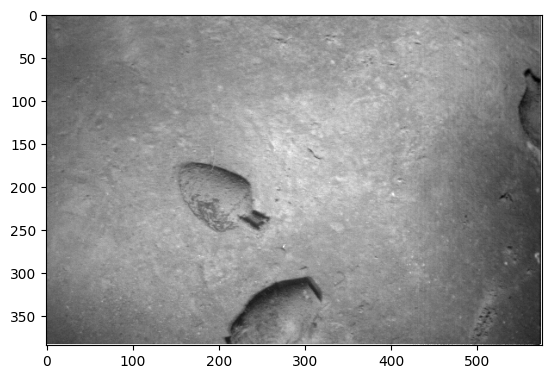

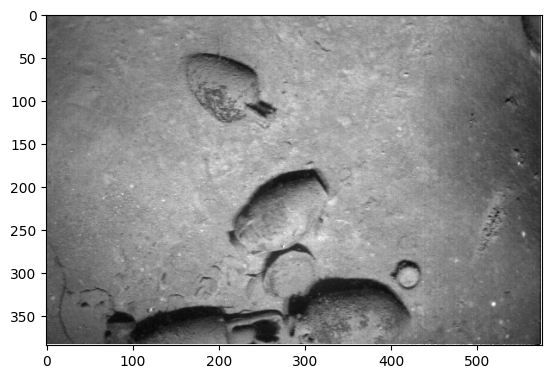

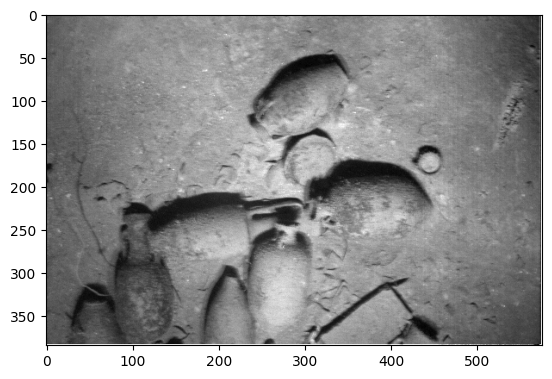

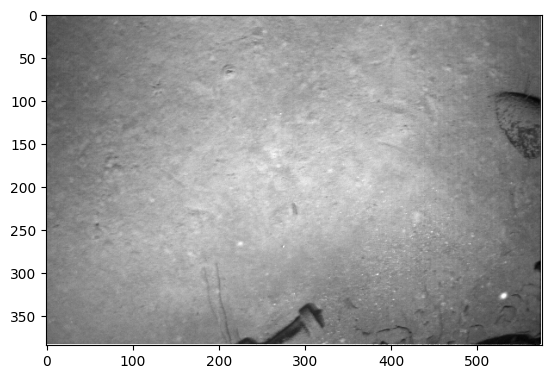

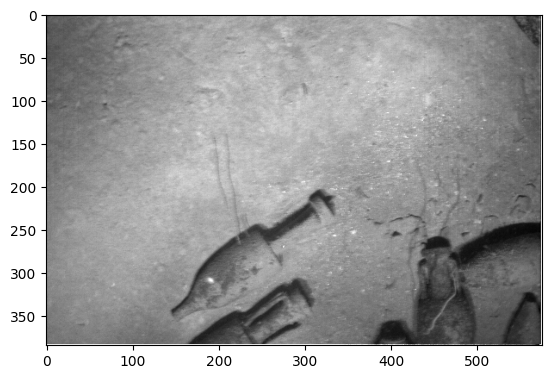

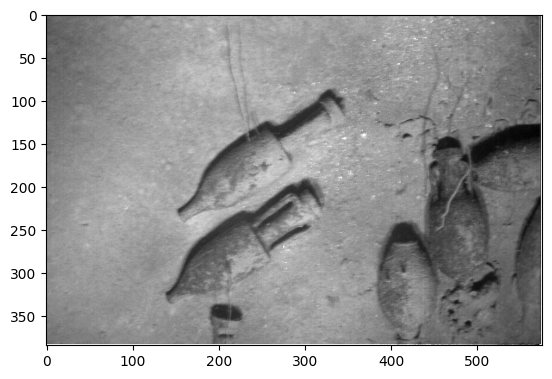

In [18]:
image_mosiacking = ImageMosiacking("six_images")

image_mosiacking.get_images_for_mosaicking()

## Get Features using SIFT Detector

Add the reason why SIFT is used.

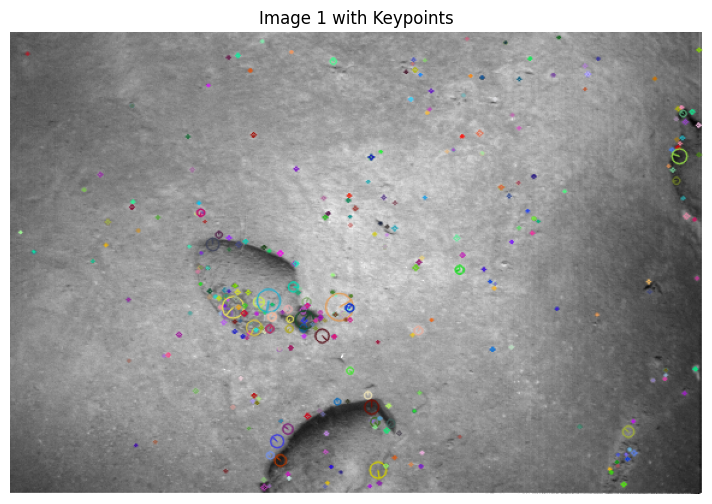

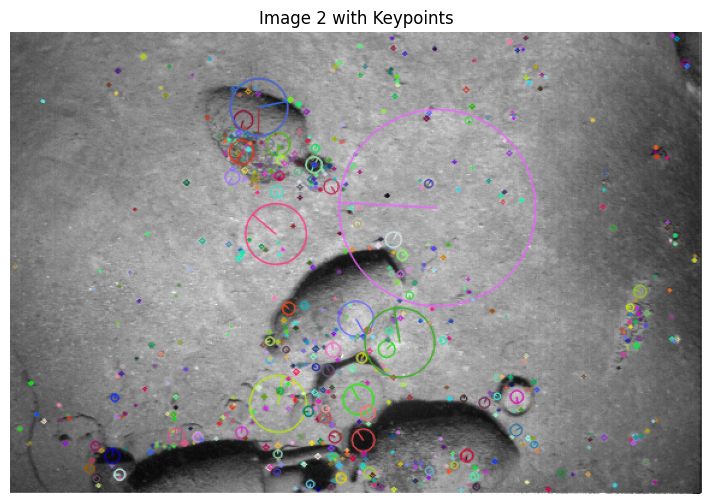

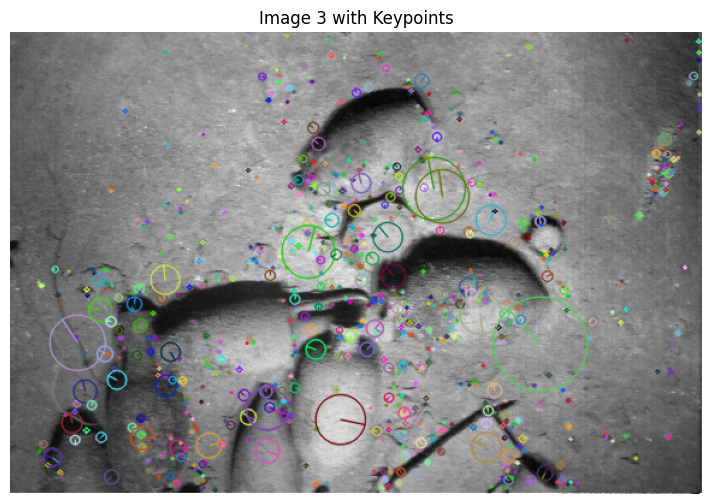

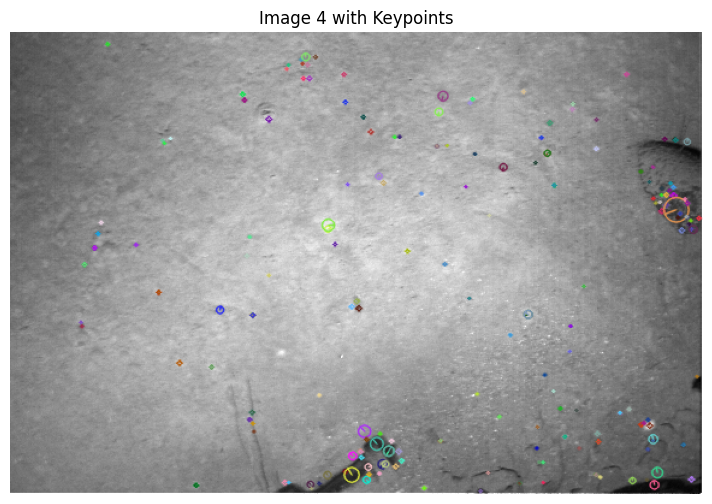

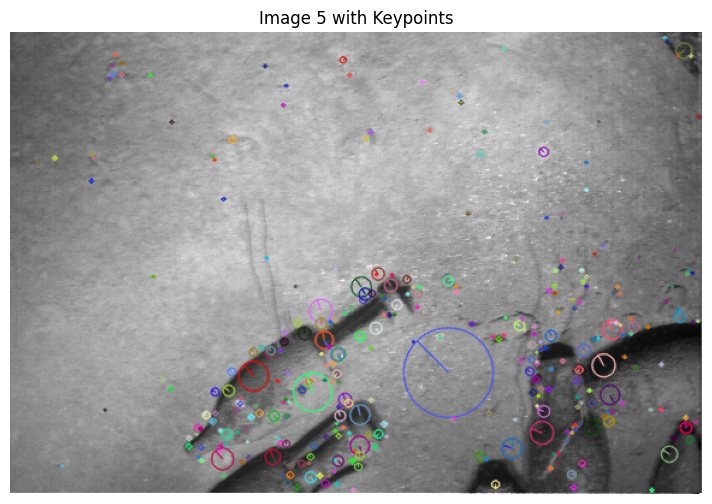

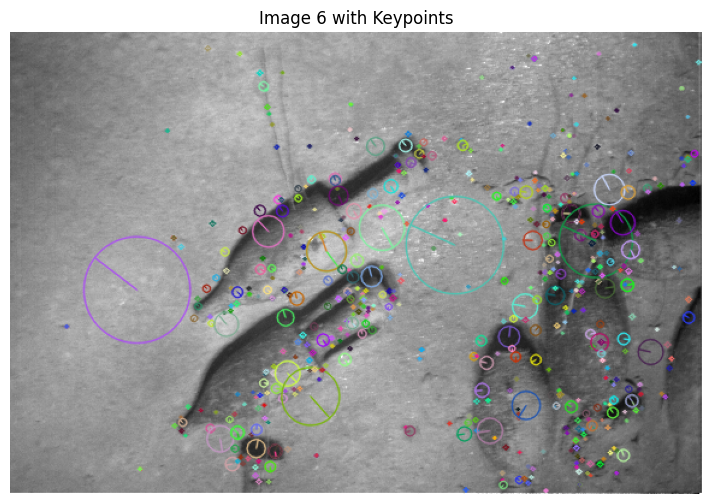

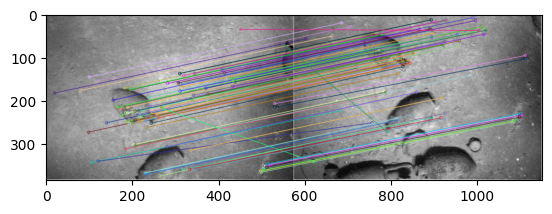

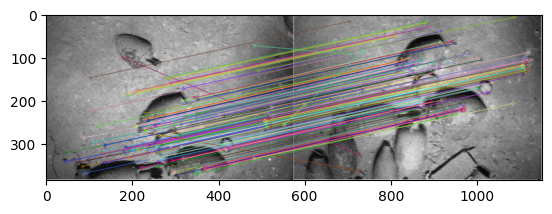

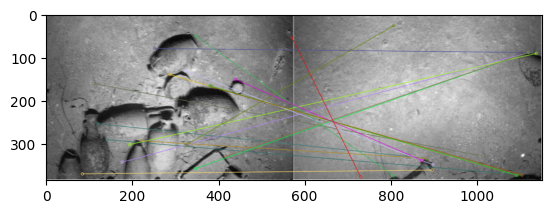

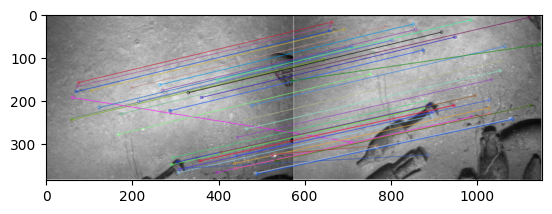

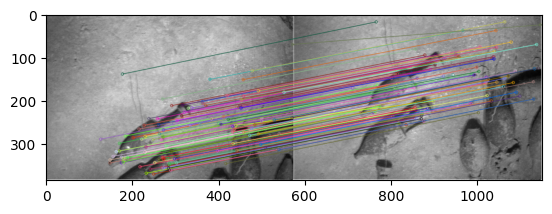

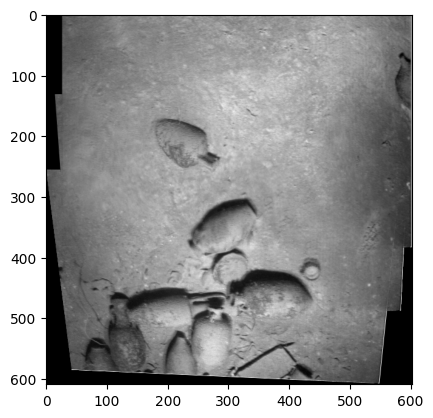

In [19]:
image_mosiacking.align_images_in_temporal_sequence()